In [225]:
######################
#import useful modules
######################

import sys

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from Modules import *
from Modules_gula import *

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText

########

import pyticles_3d_sig_sa as partF
import pyticles_sig_sa as part

########

%matplotlib inline

In [227]:
# Particles file

ncfile = 'ROCK_chd_case1.1_56_1440.nc'

###############

nc = Dataset(ncfile, 'r')

parameters = nc.simulation
base = nc.base

print(nc.variables)
nc.close()

simul = load(simul = parameters,floattype=np.float32)
depths = simul.coord[4]

#simul = load(simul = 'rockall', time=1440);


OrderedDict([('ocean_time', <class 'netCDF4._netCDF4.Variable'>
float32 ocean_time(time)
unlimited dimensions: time
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('time', <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
unlimited dimensions: time
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('px', <class 'netCDF4._netCDF4.Variable'>
float64 px(time, nq)
unlimited dimensions: time
current shape = (1440, 47350)
filling on, default _FillValue of 9.969209968386869e+36 used), ('py', <class 'netCDF4._netCDF4.Variable'>
float64 py(time, nq)
unlimited dimensions: time
current shape = (1440, 47350)
filling on, default _FillValue of 9.969209968386869e+36 used), ('pz', <class 'netCDF4._netCDF4.Variable'>
float64 pz(time, nq)
unlimited dimensions: time
current shape = (1440, 47350)
filling on, default _FillValue of 9.969209968386869e+36 used), ('pt', <class 'netCDF4._netCDF4.Variable'>
float64 pt(time, nq)
unl

In [228]:
###################################################################################
# Get positions (px,py,pz) and T,S for each particule
###################################################################################

# where
lim1,lim2 = 0,-1

##############

def load_p(name):  
    px = ionetcdf.get(ncfile,name,simul)
    time_add = 0
    return px[:,lim1:lim2],time_add-lim1


#############
    
def load_time():  
    time = ionetcdf.get(ncfile,'ocean_time',simul)
    time_int=range(simul.time0,simul.ncname.tend+simul.dtime,simul.dtime)[:len(time)]
    return time[lim1:lim2],time_int[lim1:lim2]

###############


def make_plot(which_plot,filetime=0,ipart=[0]):
    proc=mp.Process(target=which_plot, args=(filetime,ipart))
    proc.daemon=True; proc.start(); 
    print( proc, proc.is_alive())
    proc.join()
    print( proc, proc.is_alive())




In [229]:
###########################
# get time
###########################

time,time_int = load_time()

time_int = range(1440,0,-1)[lim1:lim2]

###########################
# Get px,py
###########################

px,time_add = load_p('px')
py,time_add = load_p('py')

pt,time_add = load_p('pt')
ps,time_add = load_p('ps')

ps[ps==0] = np.nan
pt[np.isnan(ps)] = np.nan

pdepth,time_add= load_p('pdepth')
pdepth[np.isnan(pt)] = np.nan

prho1,time_add= load_p('prho1')
prho1[np.isnan(pt)] = np.nan

prho1 += simul.rho0-1000.

plon,time_add = load_p('plon')
plat,time_add = load_p('plat')
plon[np.isnan(pt)] = np.nan
plat[np.isnan(pt)] = np.nan

###########################
# Compute pvrt 
###########################

print('vrt...')
try:
   pvrt,time_add= load_p('pvrt') #/np.mean(simul.f)
   pvrt[np.isnan(pt)] = np.nan
except:   
   pvrt=None; print('pvrt not in file')
   
###########################
# Compute pv 
###########################

print('pv...')
try:
    ppv,time_add = load_p('ppv')
    ppv[np.isnan(pt)] = np.nan
except: 
    ppv=None; print("no pv in file")

    
###########################     
# Compute ptopo (topography at each particule position)
###########################

print('topo...')
ptopo = copy(pdepth); ptopo[:]=np.nan
for it in range(ptopo.shape[1]):
    ptopo[:,it] = part.map_topo(simul,px[:,it],py[:,it])   
ptopo[ptopo==0] = np.nan
ptopo[np.isnan(pt)] = np.nan

#############

nq = px.shape[0]
ntime = px.shape[1]
nqmx  = nq

'''#############
# for continuous seeding
for iq in range(nq):
    if ps[iq,0]==0: 
        nqmx = iq
        print nqmx
        break
'''

vrt...
pv...
topo...


'#############\n# for continuous seeding\nfor iq in range(nq):\n    if ps[iq,0]==0: \n        nqmx = iq\n        print nqmx\n        break\n'

In [230]:
# Masking particles:

###################################################################################
# Define the mask (which particules to plot)
###################################################################################

def define_mask():

    mask0=[]; mask1=[]; mask2=[]

    vrtlim = -0.1; #vrtlim1 = -0.2; vrtlim2 = -0.3
    rholim = 27.2
    rholim1 = 27.8

    mytime = simul.dtime * (1440 - simul.time0);

    
    maskname='classic'
    
    if maskname=='classic':
        
        for iq in range(nq):
            if (pvrt[iq,mytime]<vrtlim) and (rholim1>prho1[iq,mytime]>rholim) and (pdepth[iq,mytime]>-2000): 
                mask0.append(iq)
                #if (pvrt[iq,mytime]<vrtlim1): mask1.append(iq)
                #if (pvrt[iq,mytime]<vrtlim2): mask2.append(iq)

        
    elif maskname=='south_only':
        
        for iq in range(nq):
            if (pvrt[iq,mytime]<vrtlim) and (rholim1>prho1[iq,mytime]>rholim) and (pdepth[iq,mytime]>-2000) \
                and (np.nanmin(plat[iq,:])<53):
                     
                mask0.append(iq)
                #if (pvrt[iq,mytime]<vrtlim1): mask1.append(iq)
                #if (pvrt[iq,mytime]<vrtlim2): mask2.append(iq)

                
                

    maskname = maskname + '_rho_' + format(rholim)+'_' + format(rholim1)  + '_vrt_' +  format(-vrtlim) 


        
    print('nb of particules in mask is' , len(mask0))

    return maskname, mask0


#########################


maskname, mask0 = define_mask()

itime=0; ipart = mask0


nb of particules in mask is 18734


In [231]:
# Plotting paramters


cbarlabelsize = 6
fontsize0 = 10
fontsize1 = 12
fontsize2 = format(22)
fontsize3 = format(28)
font = {'size'   : fontsize1}
plt.rc('font', **font)


time of simulation is: 1440
/net/libra/local/tmp/1//gula/ROMS/Simulations/POLGYR/rockall_his.01440.nc
coord_z [1018, 1022, 1474, 1705]


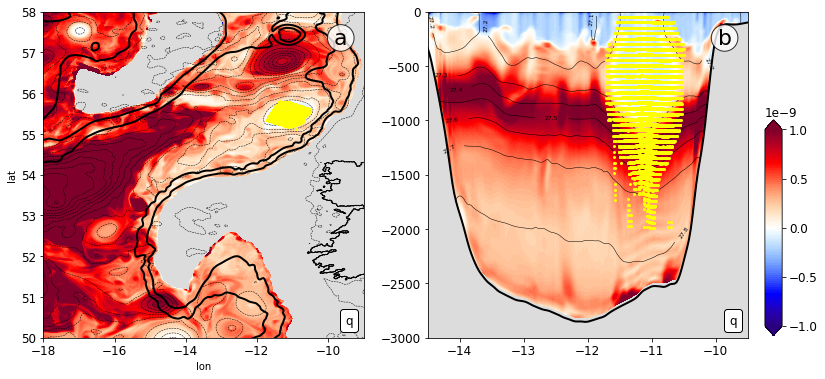

In [232]:


#########################
#Define simulation time

filetime_var = time_int[0]
itime=simul.dtime * (filetime_var - simul.time0); 
simul.update(filetime_var); 

#########################
#Define DOMAIN

coord = part.subsection(px[ipart,itime], py[ipart,itime], ny=simul.coordmax[1], nx=simul.coordmax[3],\
                        offset=400); 


x = simul.x[coord[2]:coord[3],coord[0]:coord[1]]
y = simul.y[coord[2]:coord[3],coord[0]:coord[1]]
coefx = 1./np.mean(simul.pm)/1000.
i0=coord[2]+base; j0=coord[0]+base;

xvar, yvar = x,y

#########################

varname_var = 'pv'

#########################

marksize=2.; s=1


if varname_var in ['temp','salt']: colorpoint = 'white'; colorpointedge='white'
else: colorpoint='yellow'; colorpointedge='yellow'

#########################


if varname_var in ['ct','temp']:
    my_cmap=plot.ncview_colormap('jaisnc')
    levelsvars= np.arange(10.,12.,0.1)
    levelsvar= np.arange(3.,12.,0.1)
    
elif varname_var in ['pv']:
    my_cmap=plot.ncview_colormap('blu_red')
    levelsvar= np.linspace(-1,1,100)*1e-9
    levelsvars= levelsvar   
    xvar, yvar = tools.rho2psi(x),tools.rho2psi(y)
    
elif varname_var in ['vrt']:
    my_cmap=plot.ncview_colormap('blu_red')
    levelsvar= np.linspace(-1,1,100)*0.5
    levelsvars= levelsvar   
    xvar, yvar = tools.rho2psi(x),tools.rho2psi(y)
    
else:
    my_cmap=plot.ncview_colormap('jaisnb')
    levelsvar= np.arange(35.,35.8,0.02)

###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));


###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#########################
# Get some variables

depth = np.mean(pdepth[ipart,itime])

#myvar = var(varname_var,simul,coord=coord, depths=[depth]).data

myvar2 = var('zeta',simul,coord=coord, depths=[depth]).data #+ simul.rho0 - 1000.


#levelsvar2 = np.linspace(26.,28.,100);
levelsvar2 = np.linspace(-2.,2.,100);

###########################################################################################################

plt.contourf(xvar,yvar,myvar,levelsvars,cmap=my_cmap,extend='both'); #plt.colorbar(ticks=oldsim.clabels(levelsvar_var),shrink=0.5); 
#plt.contour(x,y,rho1,levelsvar_rho1, colors = ('k',), linewidths = (0.5,)); del rho1


#plt.colorbar(shrink=0.5); 

plt.contour(x,y,myvar2,levelsvar2, colors = ('k',), linewidths = (0.5,)); del myvar2

#####################
#velocity field
#####################

#nn=u0.shape[0]/10; 
#plt.quiver(x[::nn],y[::nn],u0.T[::nn,::nn],v0.T[::nn,::nn],pivot='mid',color='k',scale=15,width=0.15,
#    headwidth=5,headlength=10,headaxislength=6,
#    minlength=0,minshaft=2);
#del u0,v0,w0

#####################
# particules
#####################

plt.plot((plon[ipart,itime]),(plat[ipart,itime]),'o', markersize=marksize, markerfacecolor=colorpoint, markeredgecolor=colorpointedge); 

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,58])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################

varunit =  'q'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax1.text(.95,.95,'a', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax1.transAxes)



###########################################################################################################
#Plot vertical section at the particule position
###########################################################################################################

ax2 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################
#COORDINATES FOR VERTICAL SECTION (panel 2):

dx=100 #x-half interval

section_x=True #False

###############################
#variables for vertical section
###############################

if section_x:
    # section along x direction    
    dy0=10*5. #we are plotting on panel 2 only particules within y0+dy0, y0-dy0
    iy = 2; y0 = tools.nanmean(py[ipart,itime])
    x01, x02 = np.int(np.nanmin(px[ipart,itime])-dx), np.int(np.nanmin([np.nanmax(px[ipart,itime])+dx,coord[3]]))
    coord_z = [np.int(y0)-iy, np.int(y0)+iy, x01, x02]
    print( 'coord_z', coord_z)
    
    myvar_z = var(varname_var,simul,coord=coord_z).data[:,iy,:]
    
    myvar2_z = var('rho1',simul,coord=coord_z).data[:,iy,:]+simul.rho0-1000.
    levelsvar2_z = np.arange(27.,28.,0.1);
    
    topo = simul.topo[coord_z[2]:coord_z[3],coord_z[0]:coord_z[1]][:,iy]
    [z_r,z_w] = tools.get_depths(simul, coord=coord_z)

    # define lon in 3d
    lat3d = copy(z_r)
    for iz in range(lat3d.shape[2]):
        lat3d[:,:,iz] = simul.x[coord_z[2]:coord_z[3],coord_z[0]:coord_z[1]]

    lat3d_w = copy(z_w)
    for iz in range(lat3d_w.shape[2]):
        lat3d_w[:,:,iz] = simul.x[coord_z[2]:coord_z[3],coord_z[0]:coord_z[1]]

    #####
    # Particles

    for iq in ipart:
        if np.abs(py[iq,itime]-y0)<dy0:
            plt.plot(plon[iq,itime],pdepth[iq,itime],'o', markersize=marksize, markerfacecolor=colorpoint, markeredgecolor=colorpointedge); 


if varname_var in ['pv']:
    joe = plt.contourf(tools.rho2psi(lat3d_w)[:,iy,:], tools.rho2psi(z_w)[:,iy,:], myvar_z,levelsvar,cmap=my_cmap,extend='both'); 
elif varname_var in ['vrt']:
    joe = plt.contourf(tools.rho2psi(lat3d)[:,iy,:], tools.rho2psi(z_r)[:,iy,:], myvar_z,levelsvar,cmap=my_cmap,extend='both'); 
else:
    joe = plt.contourf(lat3d[:,iy,:], z_r[:,iy,:],myvar_z,levelsvar,cmap=my_cmap,extend='both'); 
    
if varname_var not in ['pv']: plt.colorbar(shrink=0.5);

CS1 = plt.contour(lat3d[:,iy,:], z_r[:,iy,:],myvar2_z,levelsvar2_z, colors = ('k',), linewidths = (0.5,)); 
plt.clabel(CS1, fmt = '%2.1f', colors = 'k', fontsize=6)

#pyl.contour(xvar*coefx,yvar,w.T,levelsvar3, colors = ('y',), linewidths = (0.5,));
plt.plot(lat3d[:,iy,0], z_w[:,iy,0],'-k',lw=2.);

plt.axis([-14.5, -9.5, -3000, 0])

#####################

varunit =  'q'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax2.text(.95,.95,'b', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax2.transAxes)


###
#cb = fig.colorbar(joe,ticks=oldsim.clabels(levels),shrink=0.5)
cbar_ax = fig.add_axes([0.96, 0.13, 0.02, 0.5])
cb = fig.colorbar(joe, cax=cbar_ax,ticks=tools.clabels(levelsvars))
cb.formatter.set_powerlimits((0, 0))
cb.ax.yaxis.set_offset_position('left')
cb.update_ticks()
####

##################

plt.subplots_adjust(right=0.94)
#plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.savefig(varname_var+ maskname  + '_time_' +'{0:03}'.format(filetime_var) +'.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



nb of particules in mask is 18734


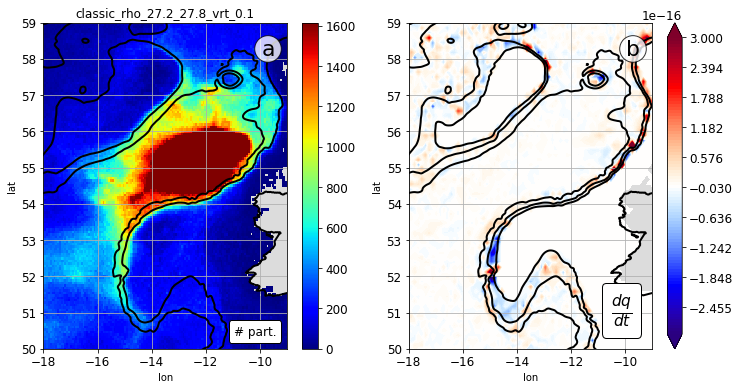

In [233]:
# Masking particles:

###################################################################################
# Define the mask (which particules to plot)
###################################################################################

maskname, mask0 = define_mask()

########################
# density of particles
########################


itime=0; ipart = mask0





if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 1.5
    levelsvar_pv = np.linspace(-1,1,100)* 1e-15 * 1.2
    
elif maskname == 'classic_rho_27.2_27.3_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 0.5
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.08
    
elif maskname == 'classic_rho_27.2_27.8_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 1.5
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.3

        
elif maskname == 'classic_rho_27.2_27.8_vrt_0.2':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 0.75
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.1
    
else:
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.015
    levelsvar_pv = np.linspace(-1,1,100)*0.3e-15
    
    
    


###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#####################
# particules
#####################

plon[np.isnan(plon)] = 0.
plat[np.isnan(plat)] = 0.

H, xedges, yedges, _ = st.binned_statistic_2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(),plon[ipart,:].ravel(),\
                                           'count', bins = 1000)
#H, xedges, yedges = np.histogram2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(), bins=1000)
# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero


# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,Hmasked, cmap=plt.cm.jet,\
               edgecolors='none',vmin=np.min(levelsvar_dens), vmax=np.max(levelsvar_dens),\
               alpha=1.,rasterized=True)

plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59]); plt.grid()

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

t1 = plt.title( maskname,fontsize='12');


#####################

varunit =  '# part.'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax1.text(.95,.95,'a', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax1.transAxes)


###############################################################
# dPV
###############################################################


ax2 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################################################
# particules
#####################

dppv = (ppv[ipart,1:] - ppv[ipart,:-1])/(time[1] - time[0])
dppv[np.isnan(dppv)] = 0.

dpdepth = 0.5 * (pdepth[ipart,1:] + pdepth[ipart,:-1])
dppv[dpdepth>-500] = 0.

dplon = 0.5 * (plon[ipart,1:] + plon[ipart,:-1])
dplat = 0.5 * (plat[ipart,1:] + plat[ipart,:-1])

H, xedges, yedges, _= st.binned_statistic_2d(dplon.ravel(),dplat.ravel(),\
                                                    dppv.ravel(), 'mean', bins=500)

# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
#H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero



# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, cmap=plot.ncview_colormap('blu_red'),\
#               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
#               alpha=1.,rasterized=True)
plt.contourf(0.5 * (xedges[1:] + xedges[1:]),0.5 * (yedges[1:] + yedges[1:]),H, cmap=plot.ncview_colormap('blu_red'),\
               levels = levelsvar_pv, extend='both')
plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,500,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59]); plt.grid()
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')


#####################

varunit =  r'$\frac{dq}{dt}$'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax2.text(.95,.95,'b', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax2.transAxes)


#####################

plt.savefig('density_dpv_mean_'+ maskname + '_time_' +  format(filetime_var) + '.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



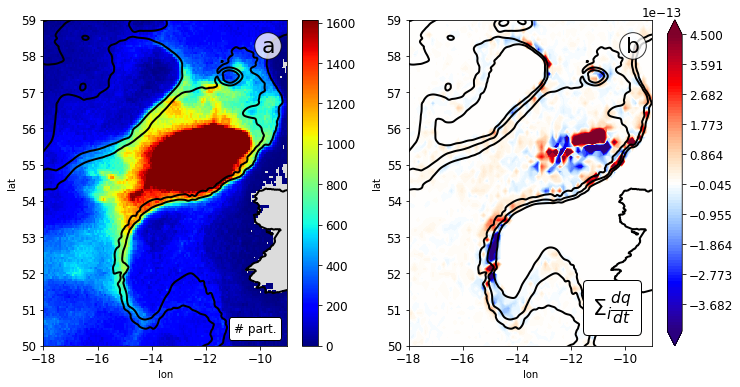

In [234]:




levelsvar_pvsum = levelsvar_pv*1.5e3



###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#####################
# particules
#####################

plon[np.isnan(plon)] = 0.
plat[np.isnan(plat)] = 0.

H, xedges, yedges, _ = st.binned_statistic_2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(),plon[ipart,:].ravel(),\
                                           'count', bins = 1000)
#H, xedges, yedges = np.histogram2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(), bins=1000)
# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero

    
    
# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,Hmasked, cmap=plt.cm.jet,\
               edgecolors='none',vmin=np.min(levelsvar_dens), vmax=np.max(levelsvar_dens),\
               alpha=1.,rasterized=True)

plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')


#####################

varunit =  '# part.'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax1.text(.95,.95,'a', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax1.transAxes)



###############################################################
# PV
###############################################################


ax2 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################################################
# particules
#####################

dppv = (ppv[ipart,1:] - ppv[ipart,:-1])/(time[1] - time[0])
dppv[np.isnan(dppv)] = 0.

dpdepth = 0.5 * (pdepth[ipart,1:] + pdepth[ipart,:-1])
dppv[dpdepth>-500] = 0.

dplon = 0.5 * (plon[ipart,1:] + plon[ipart,:-1])
dplat = 0.5 * (plat[ipart,1:] + plat[ipart,:-1])

H, xedges, yedges, _= st.binned_statistic_2d(dplon.ravel(),dplat.ravel(),\
                                                    dppv.ravel(), 'sum', bins=500)

# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
#H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero


# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, cmap=plot.ncview_colormap('blu_red'),\
#               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
#               alpha=1.,rasterized=True)
plt.contourf(0.5 * (xedges[1:] + xedges[1:]),0.5 * (yedges[1:] + yedges[1:]),H, cmap=plot.ncview_colormap('blu_red'),\
               levels = levelsvar_pvsum, extend='both')
plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,500,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################

varunit =  r'$\Sigma_i \frac{dq}{dt}$'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax2.text(.95,.95,'b', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax2.transAxes)



#####################

plt.savefig('density_dpv_sum_' + maskname + '_time_' + format(filetime_var) + '_count.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



In [235]:
dppv0 = copy(dppv)
dppv0[dplat>53.5] = np.nan


dppv1 = copy(dppv)
dppv1[dplat<54.] = np.nan
dppv1[dplat>56.5] = np.nan
dppv1[dplon<-14.] = np.nan


print(np.nansum(dppv))
print(np.nansum(dppv0))
print(np.nansum(dppv1))
print(np.nansum(dppv1) + np.nansum(dppv0))

-1.8857808e-12
-7.774037e-12
4.2974474e-12
-3.4765892e-12


nb of particules in mask is 18734


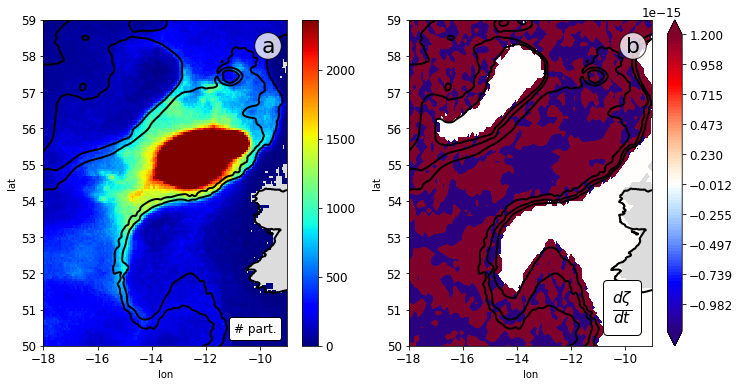

In [236]:
# Masking particles:

###################################################################################
# Define the mask (which particules to plot)
###################################################################################

maskname, mask0 = define_mask()

########################
# density of particles
########################


itime=0; ipart = mask0



###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#####################
# particules
#####################

plon[np.isnan(plon)] = 0.
plat[np.isnan(plat)] = 0.

H, xedges, yedges, _ = st.binned_statistic_2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(),plon[ipart,:].ravel(),\
                                           'count', bins = 1000)
#H, xedges, yedges = np.histogram2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(), bins=1000)
# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero

if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.015
else:
    levelsvar = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.015

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,Hmasked, cmap=plt.cm.jet,\
               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
               alpha=1.,rasterized=True)

plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################

varunit =  '# part.'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax1.text(.95,.95,'a', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax1.transAxes)




###############################################################
# PV
###############################################################


ax2 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################################################
# particules
#####################

dpvrt = (pvrt[ipart,1:] - pvrt[ipart,:-1])/(time[1] - time[0])
dpvrt[np.isnan(dpvrt)] = 0.

dpdepth = 0.5 * (pdepth[ipart,1:] + pdepth[ipart,:-1])
dpvrt[dpdepth>-500] = 0.

dplon = 0.5 * (plon[ipart,1:] + plon[ipart,:-1])
dplat = 0.5 * (plat[ipart,1:] + plat[ipart,:-1])

H, xedges, yedges, _= st.binned_statistic_2d(dplon.ravel(),dplat.ravel(),\
                                                    dpvrt.ravel(), 'mean', bins=500)

# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
#H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero



if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar = np.linspace(-1,1,100)*0.5e-6
else:
    levelsvar = np.linspace(-1,1,100)*0.3e-15*4
    
    
    

# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, cmap=plot.ncview_colormap('blu_red'),\
#               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
#               alpha=1.,rasterized=True)
plt.contourf(0.5 * (xedges[1:] + xedges[1:]),0.5 * (yedges[1:] + yedges[1:]),H, cmap=plot.ncview_colormap('blu_red'),\
               levels = levelsvar, extend='both')
plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,500,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################

varunit =  r'$\frac{d \zeta}{dt}$'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax2.text(.95,.95,'b', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax2.transAxes)



#####################

plt.savefig('density_dvrt_mean_'+ maskname + '_time_' +  format(filetime_var) + '.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



nb of particules in mask is 18734


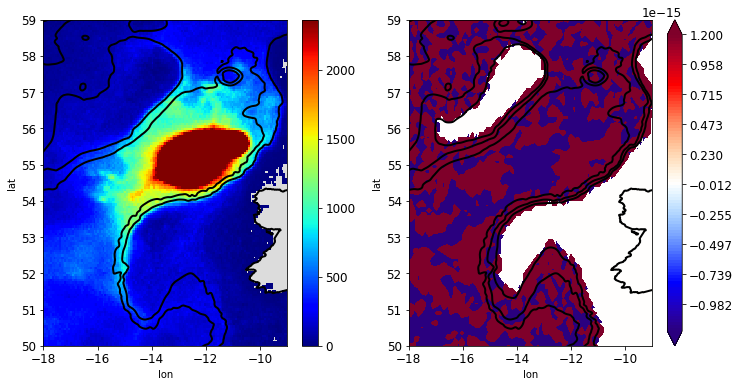

In [237]:
# Masking particles:

###################################################################################
# Define the mask (which particules to plot)
###################################################################################

maskname, mask0 = define_mask()

########################
# density of particles
########################


itime=0; ipart = mask0



###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#####################
# particules
#####################

plon[np.isnan(plon)] = 0.
plat[np.isnan(plat)] = 0.

H, xedges, yedges, _ = st.binned_statistic_2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(),plon[ipart,:].ravel(),\
                                           'count', bins = 1000)
#H, xedges, yedges = np.histogram2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(), bins=1000)
# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero

if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.015
else:
    levelsvar = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.015

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,Hmasked, cmap=plt.cm.jet,\
               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
               alpha=1.,rasterized=True)

plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')




###############################################################
# PV
###############################################################


ax1 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################################################
# particules
#####################

dpvrt = (pvrt[ipart,1:] - pvrt[ipart,:-1])/(time[1] - time[0])
dpvrt[np.isnan(dpvrt)] = 0.

dpdepth = 0.5 * (pdepth[ipart,1:] + pdepth[ipart,:-1])
dpvrt[dpdepth>-500] = 0.

dplon = 0.5 * (plon[ipart,1:] + plon[ipart,:-1])
dplat = 0.5 * (plat[ipart,1:] + plat[ipart,:-1])

H, xedges, yedges, _= st.binned_statistic_2d(dplon.ravel(),dplat.ravel(),\
                                                    dpvrt.ravel(), 'sum', bins=500)

# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
#H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero



if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar = np.linspace(-1,1,100)*0.5e-6 * 5e2
else:
    levelsvar = np.linspace(-1,1,100)*0.3e-15*4
    
    
    

# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, cmap=plot.ncview_colormap('blu_red'),\
#               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
#               alpha=1.,rasterized=True)
plt.contourf(0.5 * (xedges[1:] + xedges[1:]),0.5 * (yedges[1:] + yedges[1:]),H, cmap=plot.ncview_colormap('blu_red'),\
               levels = levelsvar, extend='both')
plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,500,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################



#####################

plt.savefig('density_dvrt_sum_'+ maskname + '_time_' +  format(filetime_var) + '.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



Text(0.5, 0, '${\\rm time}\\,{\\rm (days)}$')

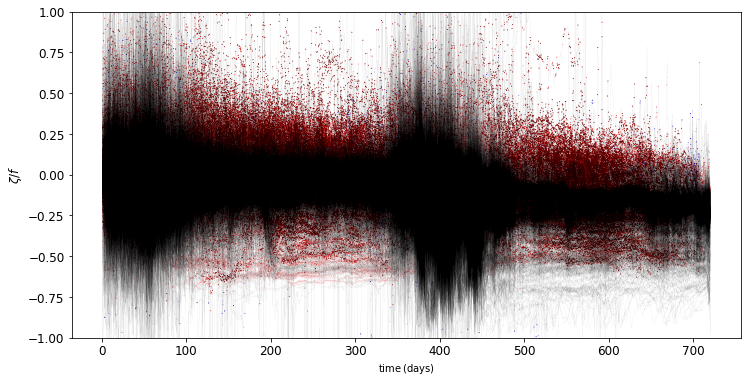

In [238]:
itime0=0; itime1=-1

time_days = np.array(time_int) * simul.dt / 3600. / 24.

ipart = mask0[::10]


###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################


varname_2='vrt'

varname_points='pv'; 


if varname_points=='vrt':
    levelsvar_points = levelsvar_var =  np.linspace(-1,1,100)*0.5
elif varname_points=='pv':
    levelsvar_points = levelsvar_var =  np.linspace(-1,1,100)*1e-9
elif varname_points=='salt':
    levelsvar_points = levelsvar_var =  np.linspace(36.0,36.4,200)

###########################################################################################################


#increase linewidth depending on the number of lines
lw = 0.1/np.sqrt(len(ipart))*10
marksize=2.; s=1

####################################
ax1 = plt.subplot(1,1,1)  
####################################

if varname_2=='temp': pvar2 = pt; title = r'$T \, (^{\circ} C)$'
elif varname_2=='salt': pvar2 = ps; title = r'$S \, $'
elif varname_2=='rho1': pvar2 = prho1; title = r'$\rho \, ({\rm kg}\,{\rm m}^{-3})$'
elif varname_2=='vrt': pvar2 = pvrt; title = r'$\zeta/f$'
    
################### 

plt.plot(time_days,pvar2[ipart,:].T,'k',lw=lw); 

#plt.plot([time_int[itime], time_int[itime]], [np.nanmin(pvar2[ipart,:]), np.nanmax(pvar2[ipart,:])],'k--',lw=1.5);
#plt.text(time_int[itime]+1, np.nanmin(pvar2[ipart,itime0:itime1]),r'$t_m$',fontsize='16');
#plt.plot([time_int[0], time_int[0]], [np.nanmin(pvar2[ipart,:]), np.nanmax(pvar2[ipart,:])],'k--',lw=1.5);
#plt.text(time_int[0]-15, np.nanmin(pvar2[ipart,itime0:itime1])+0.05,r'$t_s$',fontsize='16');

################### 

    
if varname_points=='pv':   

    ppv_neg = copy(ppv[ipart,:]); 
    prho_neg = copy(pvar2[ipart,:]); 
    #prho_neg[ppv_neg>=0] = np.nan  

    for iq in range(len(ipart)):
        plt.scatter(time_days,prho_neg[iq,:].T, c=ppv_neg[iq,:].T, cmap=plot.colormap('pv'),\
                    s=s, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points))

elif varname_points=='temp':
    for iq in range(len(ipart)):
        plt.scatter(time_days,pvar2[ipart[iq],:].T, c=pt[ipart[iq],:].T, \
                    cmap=plot.colormap(varname_points),s=s, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points) )      
elif varname_points=='salt':
    for iq in range(len(ipart)):
        plt.scatter(time_days,pvar2[ipart[iq],:].T, c=ps[ipart[iq],:].T, \
                    cmap=plot.colormap(varname_points),s=s, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points) )         
elif varname_points=='rho':
    for iq in ipart:
        plt.scatter(time_days,pvar2[iq,:].T, c=prho[iq,:].T, cmap=plot.colormap(varname_points),\
                    s=s, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points) )  
elif varname_points=='vrt':
    for iq in ipart:
        plt.scatter(time_days,pvar2[iq,:].T, c=pvrt[iq,:].T, cmap=plot.colormap(varname_points),\
                    s=s, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points) )  
else:
    for iq in range(len(ipart)):
        plt.scatter(time_days,pvar2[ipart[iq],:].T, c=pt[ipart[iq],:].T, cmap=plot.colormap('temp'),\
                    s=s, edgecolors='none',vmin=np.min(levelsvar_temp), vmax=np.max(levelsvar_temp) )
        
        
#plt.xlim([np.nanmin([time_int[itime0],time_int[itime1]]),10+np.nanmax([time_int[itime0],time_int[itime1]])])
#plt.ylim([np.nanmin(pvar2[ipart,:])-0.1, np.nanmax(pvar2[ipart,:])+0.1])

plt.ylim([-1,1])

plt.ylabel(title,fontsize='12')
plt.xlabel(r'${\rm time}\,{\rm (days)}$',fontsize='10')







In [353]:
# Rescale particles

latlim1 = 53.5
latlim2 = 57
# Masking particles:

###################################################################################
# Define the mask (which particules to plot)
###################################################################################

def define_mask_refined():

    mask0=[];

    vrtlim = -0.1;
    rholim = 27.2
    rholim1 = 27.8
    
    dtime = 30
    ntime = px.shape[1]
    
    mytime = simul.dtime * (1440 - simul.time0);
    plon2, plat2 = copy(plon), copy(plat)
        
        
    maskname='exiting_only'
    
    if maskname=='exiting_only':
        
        for iq in range(nq):
            if (pvrt[iq,mytime]<vrtlim) and (rholim1>prho1[iq,mytime]>rholim) and (pdepth[iq,mytime]>-2000) \
                and ((np.nanmin(plat[iq,:ntime-dtime])<latlim1) or (np.nanmax(plat[iq,:ntime-dtime])>latlim2)):
                     
                mask0.append(iq)
                #if (pvrt[iq,mytime]<vrtlim1): mask1.append(iq)
                #if (pvrt[iq,mytime]<vrtlim2): mask2.append(iq)
                
                iout1 = np.nanargmax(plat[iq,:]<latlim1)
                iout2 = np.nanargmax(plat[iq,:]>latlim2)
                
                if iout1*iout2>0:  iout = np.min([iout1,iout2])
                else: iout = np.max([iout1,iout2])
                    
                #print('iout',iout)
                
                if iout + dtime < ntime:
                    plon2[iq,iout + dtime:] = np.nan
                    plat2[iq,iout + dtime:] = np.nan 
                    plon2[iq,:iout] = np.nan
                    plat2[iq,:iout] = np.nan 

    maskname = maskname + '_rho_' + format(rholim)+'_' + format(rholim1)  + '_vrt_' +  format(-vrtlim) 

        
    print('nb of particules in mask is' , len(mask0))

    return maskname, mask0, plon2, plat2


#########################


maskname, mask0, plon2, plat2 = define_mask_refined()


itime=0; ipart = mask0


nb of particules in mask is 15345


Text(0, 0.5, 'lat')

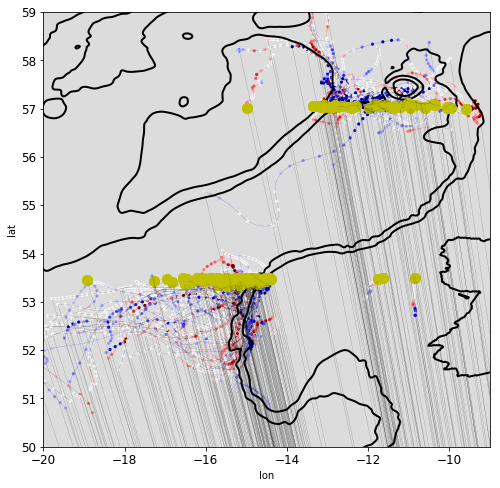

In [357]:
sample=[mask0[i] for i in range(200,len(mask0),100)]

###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(8.0,8.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(111, facecolor='Gainsboro')     

#####################
# particules
#####################

varname_points='vrt'

if varname_points=='vrt':
    levelsvar_points = levelsvar_var =  np.linspace(-1,1,100)*0.5; pvar = pvrt
elif varname_points=='pv':
    levelsvar_points = levelsvar_var =  np.linspace(-1,1,100)*1e-9; pvar = ppv
elif varname_points=='salt':
    levelsvar_points = levelsvar_var =  np.linspace(35.3,36.0,200); pvar = ps


for iq in sample:
    plt.plot(plon2[iq,:],plat2[iq,:],'k',lw=0.1)
    plt.scatter(plon2[iq,:],plat2[iq,:], c=pvar[iq,:], cmap=plot.colormap(varname_points),\
                        s=10, edgecolors='none',vmin=np.min(levelsvar_points), vmax=np.max(levelsvar_points))


    iout1 = np.nanargmax(plat[iq,:]<latlim1)
    iout2 = np.nanargmax(plat[iq,:]>latlim2)

    if iout1*iout2>0:  iout = np.min([iout1,iout2])
    else: iout = np.max([iout1,iout2])
    
    plt.plot(plon2[iq,iout],plat2[iq,iout],'o',markersize=10, markerfacecolor='y', markeredgecolor='y')
    plt.plot(plon2[iq,iout],plat2[iq,iout],'o',markersize=10, markerfacecolor='y', markeredgecolor='y')

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-20,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')




In [355]:
'''for iq in sample:
    
                
    iout1 = np.nanargmax(plat[iq,:]<latlim1)
    iout2 = np.nanargmax(plat[iq,:]>latlim2)

    if iout1*iout2>0:  iout = np.min([iout1,iout2])
    else: iout = np.max([iout1,iout2])

    print('iout',iout)
    
    print(plat2[iq,:1409])'''

iout 1377
[     nan      nan      nan ... 56.92824      nan      nan]


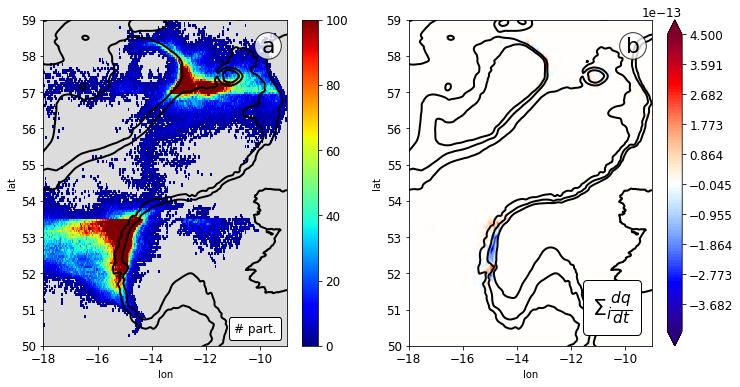

In [356]:



if maskname == 'classic_rho_27.3_27.8_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 1.5
    levelsvar_pv = np.linspace(-1,1,100)* 1e-15 * 1.2
    
elif maskname == 'classic_rho_27.2_27.3_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 0.5
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.08
    
elif maskname == 'classic_rho_27.2_27.8_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 1.5
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.3

        
elif maskname == 'classic_rho_27.2_27.8_vrt_0.2':
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.01 * 0.75
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.1
    
elif maskname == 'exiting_only_rho_27.2_27.8_vrt_0.1':
    levelsvar_dens = np.linspace(0,1,100)*100
    levelsvar_pv = np.linspace(-1,1,100)* 1.e-15 * 0.3

    
    
else:
    levelsvar_dens = np.linspace(0,1,100)*np.nanmax(Hmasked)*0.005
    levelsvar_pv = np.linspace(-1,1,100)*0.2e-15
    
    


levelsvar_pvsum = levelsvar_pv*1.5e3



###########################################################################################################
#FIGURE
###########################################################################################################

fig = plt.figure(figsize=(12.0,6.0));

###########################################################################################################
#Plot horizontal section at the particule position
###########################################################################################################

ax1 = fig.add_subplot(121, facecolor='Gainsboro')     

#####################
# particules
#####################

plon2[np.isnan(plon2)] = 0.
plat2[np.isnan(plat2)] = 0.

H, xedges, yedges, _ = st.binned_statistic_2d(plon2[ipart,:].ravel(),plat2[ipart,:].ravel(),plon2[ipart,:].ravel(),\
                                           'count', bins = 1000)
#H, xedges, yedges = np.histogram2d(plon[ipart,:].ravel(),plat[ipart,:].ravel(), bins=1000)
# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero

    
    
# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,Hmasked, cmap=plt.cm.jet,\
               edgecolors='none',vmin=np.min(levelsvar_dens), vmax=np.max(levelsvar_dens),\
               alpha=1.,rasterized=True)

plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')


#####################

varunit =  '# part.'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize1), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax1.text(.95,.95,'a', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax1.transAxes)



###############################################################
# PV
###############################################################


ax2 = fig.add_subplot(122, facecolor='Gainsboro')     

###############################################################
# particules
#####################

dppv = (ppv[ipart,1:] - ppv[ipart,:-1])/(time[1] - time[0])
dppv[np.isnan(dppv)] = 0.

dpdepth = 0.5 * (pdepth[ipart,1:] + pdepth[ipart,:-1])
dppv[dpdepth>-500] = 0.

dplon2 = 0.5 * (plon2[ipart,1:] + plon2[ipart,:-1])
dplat2 = 0.5 * (plat2[ipart,1:] + plat2[ipart,:-1])

H, xedges, yedges, _= st.binned_statistic_2d(dplon2.ravel(),dplat2.ravel(),\
                                                    dppv.ravel(), 'sum', bins=500)

# H needs to be rotated and flipped
H = np.rot90(H); H = np.flipud(H)
#H[H<1]=1; Hmasked = np.ma.masked_where(H==1,H) # Mask pixels with a value of zero


# Plot 2D histogram using pcolor
#plt.pcolormesh(xedges,yedges,H, cmap=plot.ncview_colormap('blu_red'),\
#               edgecolors='none',vmin=np.min(levelsvar), vmax=np.max(levelsvar),\
#               alpha=1.,rasterized=True)
plt.contourf(0.5 * (xedges[1:] + xedges[1:]),0.5 * (yedges[1:] + yedges[1:]),H, cmap=plot.ncview_colormap('blu_red'),\
               levels = levelsvar_pvsum, extend='both')
plt.colorbar()

#####################
# topography
#####################

plt.contour(x, y, simul.topo[coord[2]:coord[3],coord[0]:coord[1]], [20,500,1000,2000],\
             colors = ('k',), linewidths = (2.,) ); 

#####################

plt.axis([-18,-9,50,59])

#t1 = plt.title(varname_var_long + ' at ' + r'$(z_s,t_s)$' ,fontsize='12');
plt.xlabel(r'lon',fontsize='10'); plt.ylabel(r'lat',fontsize='10')

#####################

varunit =  r'$\Sigma_i \frac{dq}{dt}$'
at = AnchoredText(varunit,loc=4, prop=dict(size=fontsize2), frameon=True, )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

box = 'circle,pad=0.15'; props = dict(boxstyle=box, fc='w', ec='k', lw=1, alpha=0.8)
ax2.text(.95,.95,'b', fontsize=fontsize2,  horizontalalignment='right', verticalalignment='top',\
         bbox=props, transform=ax2.transAxes)



#####################

plt.savefig('density_dpv_sum_' + maskname + '_time_' + format(filetime_var) + '_count.png', size=None, figure=None, \
            magnification='auto', dpi=200,bbox_inches='tight')



'exiting_only_rho_27.2_27.8_vrt_0.1'